In [1]:
from model_runner import ModelRunner
from DBPN import DBPN
from SRCNN_different_specs import RunSRCNN, SRCNN
from custom_image_dataset import CustomImageDataset
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import torch
from torch import nn
from image_helper import ImageHelper
import image_patches

/Users/pedrovelozo/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATASET_ROOT="./datasets/"
DATASET_NAME = "Flickr2K"

In [3]:
PATCH_SIZE = 80

In [5]:
image_patches.create_valid_image_patches(f"{DATASET_ROOT}/{DATASET_NAME}", (PATCH_SIZE, PATCH_SIZE, 3), f"{DATASET_ROOT}/{DATASET_NAME}_{PATCH_SIZE}_{PATCH_SIZE}_train", 145)
image_patches.create_image_patches(f"{DATASET_ROOT}/{DATASET_NAME}", (PATCH_SIZE, PATCH_SIZE, 3), f"{DATASET_ROOT}/{DATASET_NAME}_{PATCH_SIZE}_{PATCH_SIZE}_validation", 20)

100%|██████████| 2651/2651 [04:31<00:00,  9.76it/s]


In [6]:
%%time
transform_x = transforms.Compose([
    transforms.Resize((PATCH_SIZE // 4, PATCH_SIZE // 4), interpolation=Image.BICUBIC),
])

transform_y = transforms.Compose([
    transforms.CenterCrop((PATCH_SIZE, PATCH_SIZE))
])

# Set up the data loaders
train_data_set = CustomImageDataset(
    img_dir=f"{DATASET_ROOT}/{DATASET_NAME}_{PATCH_SIZE}_{PATCH_SIZE}_train", transform=transform_x, target_transform=transform_y, tensor_size=PATCH_SIZE)
validation_data_set = CustomImageDataset(
    img_dir=f"{DATASET_ROOT}/{DATASET_NAME}_{PATCH_SIZE}_{PATCH_SIZE}_validation", transform=transform_x, target_transform=transform_y, tensor_size=PATCH_SIZE)

# Report split sizes
print('Training set has {} instances'.format(len(train_data_set)))
print('Validation set has {} instances'.format(len(validation_data_set)))

/Users/pedrovelozo/anaconda3/lib/python3.10/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
100%|██████████| 2650/2650 [00:31<00:00, 83.10it/s] 


Training set has 384115 instances
Validation set has 53000 instances
CPU times: user 1min 40s, sys: 49 s, total: 2min 29s
Wall time: 4min 31s


In [7]:
%%time

# https://towardsdatascience.com/7-tips-for-squeezing-maximum-performance-from-pytorch-ca4a40951259
pin_memory = False
batch_size = round(1*(2**13))

train_dataloader = DataLoader(train_data_set, batch_size=batch_size, shuffle=True, pin_memory=pin_memory) # TODO: aumentar batch_size p/ 2^12
validation_dataloader = DataLoader(validation_data_set, batch_size=batch_size, pin_memory=pin_memory)

CPU times: user 2.89 s, sys: 8.91 s, total: 11.8 s
Wall time: 16.8 s


In [8]:
# The learning rate is initialized to 1e − 4 for all layers and decrease by a factor of 10 for every 5 × 105 iterations for total 106 iterations.
lr = 1e-4
device = "cuda" if torch.cuda.is_available() else "cpu"

model = DBPN().to(device)
model_runner = ModelRunner()

# For optimization, we use Adam with momentum to 0.9 and weight decay to 1e−4.
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.LinearLR(
    optimizer,
    start_factor=1.0,
    end_factor=0.01,
    total_iters=60)

In [9]:
%%time
model_runner.train(
    model=model,
    train_dataloader=train_dataloader,
    validation_dataloader=validation_dataloader,
    optimizer=optimizer,
    epochs=100,
    scheduler=scheduler,
    loss_fn=nn.MSELoss(),
)


epoch 0
-------------------------------
Training on 384115 samples...
Batch size: 8192
Number of batches: 47


  0%|          | 0/47 [00:00<?, ?it/s]

: 

: 

In [7]:
a = torch.randn(2, 2, 3)
a = torch.unsqueeze(a, 0)
a.shape

torch.Size([1, 2, 2, 3])

In [8]:
# input = torch.randn(1, 3, 256, 256)
input = torch.randn([1, 3, 8, 8])
output = model(input)
print(output.shape)

torch.Size([1, 3, 32, 32])


[show_tensor_as_image] squeeze tensor_np.shape = (3, 132, 132)


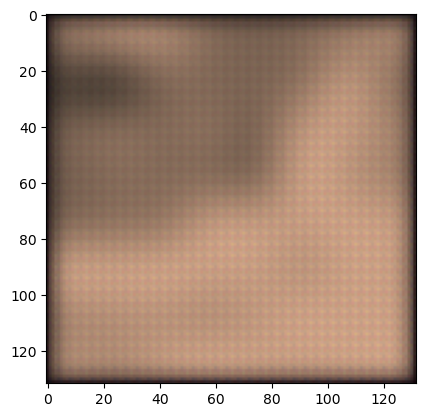

In [8]:
abc = DBPN()

image_helper = ImageHelper()
image_helper.apply_model_to_image_and_show(
    model=model,
    image=f"datasets/Set5_train/patches/baby_patch/patch_0.png",
    downsample_factor=4,
    unsqueeze=True
)

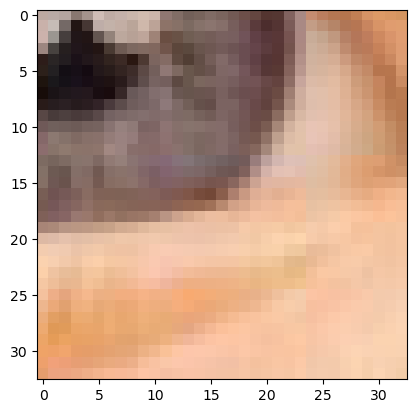

In [9]:
image_helper.open_and_show_image("datasets/Set5_train/patches/baby_patch/patch_0.png")
